# Machine Learning Estimators for Wage Prediction

We illustrate how to predict an outcome variable $Y$ in a high-dimensional setting, where the number of covariates $p$ is large in relation to the sample size $n$. So far we have used linear prediction rules, e.g. Lasso regression, for estimation.
Now, we also consider nonlinear prediction rules including tree-based methods.

## Data

Again, we consider data from the U.S. March Supplement of the Current Population Survey (CPS) in 2015.
The preproccessed sample consists of $5150$ never-married individuals.

Set the following file_directory to a place where you downloaded https://raw.githubusercontent.com/CausalAIBook/MetricsMLNotebooks/main/data/wage2015_subsample_inference.csv

In [1]:
# Import relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV, LinearRegression
from sklearn.preprocessing import StandardScaler
import patsy
import warnings
from sklearn.base import BaseEstimator
warnings.simplefilter('ignore')
np.random.seed(1234)

In [2]:
file = "https://raw.githubusercontent.com/CausalAIBook/MetricsMLNotebooks/main/data/wage2015_subsample_inference.csv"
data = pd.read_csv(file)

In [3]:
data.describe()

,wage,lwage,sex,shs,hsg,scl,clg,ad,mw,so,we,ne,exp1,exp2,exp3,exp4,occ,occ2,ind,ind2
count,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000
mean,23.410410,2.970787,0.444466,0.023301,0.243883,0.278058,0.317670,0.137087,0.259612,0.296505,0.216117,0.227767,13.760583,3.018925,8.235867,25.118038,5310.737476,11.670874,6629.154951,13.316893
std,21.003016,0.570385,0.496955,0.150872,0.429465,0.448086,0.465616,0.343973,0.438464,0.456761,0.411635,0.419432,10.609465,4.000904,14.488962,53.530225,11874.356080,6.966684,5333.443992,5.701019
min,3.021978,1.105912,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,1.000000,370.000000,2.000000
25%,13.461538,2.599837,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.250000,0.125000,0.062500,1740.000000,5.000000,4880.000000,9.000000
50%,19.230769,2.956512,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,1.000000,1.000000,1.000000,4040.000000,13.000000,7370.000000,14.000000
75%,27.777778,3.324236,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,21.000000,4.410000,9.261000,19.448100,5610.000000,17.000000,8190.000000,18.000000
max,528.845673,6.270697,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,47.000000,22.090000,103.823000,487.968100,100000.000000,22.000000,100000.000000,22.000000


In [4]:
y = np.log(data['wage']).values # Response variable
Z = data.drop(['wage', 'lwage'], axis=1) # Covariates
Z.columns

Index(['sex', 'shs', 'hsg', 'scl', 'clg', 'ad', 'mw', 'so', 'we', 'ne', 'exp1',
       'exp2', 'exp3', 'exp4', 'occ', 'occ2', 'ind', 'ind2'],
      dtype='object')

The following figure shows the weekly wage distribution from the US survey data.

Text(0.5, 1.0, 'Empirical wage distribution from the US survey data')

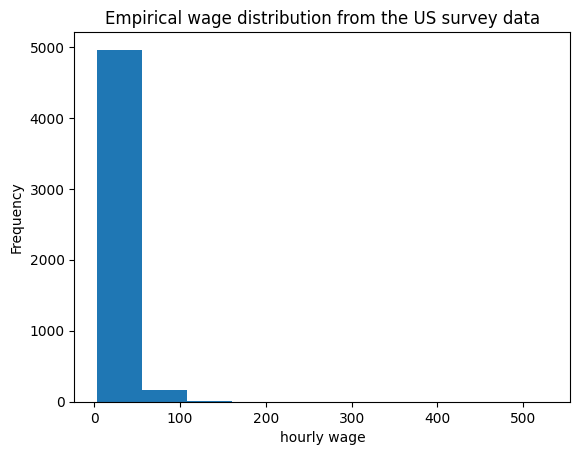

In [5]:
plt.hist(data.wage)
plt.xlabel('hourly wage')
plt.ylabel('Frequency')
plt.title('Empirical wage distribution from the US survey data')

Text(0.5, 1.0, 'Empirical log wage distribution from the US survey data')

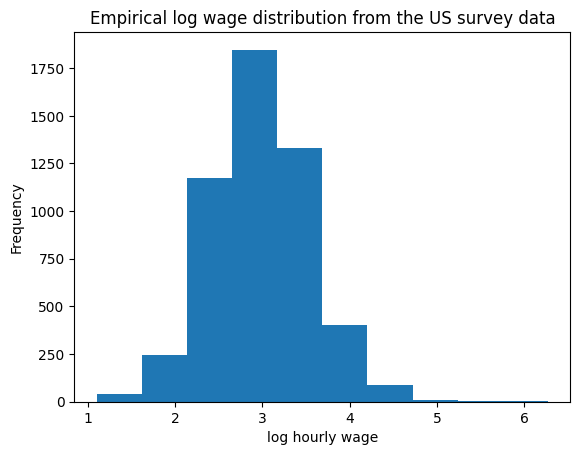

In [6]:
plt.hist(np.log(data.wage))
plt.xlabel('log hourly wage')
plt.ylabel('Frequency')
plt.title('Empirical log wage distribution from the US survey data')

Wages show a high degree of skewness. Hence, wages are transformed in almost all studies by
the logarithm.

## Analysis

Due to the skewness of the data, we are considering log wages which leads to the following regression model

$$\log(\operatorname{wage}) = g(Z) + \epsilon.$$

We will estimate the two sets of prediction rules: Linear and Nonlinear Models.
In linear models, we estimate the prediction rule of the form

$$\hat g(Z) = \hat \beta'X.$$
Again, we generate $X$ in two ways:

1. Basic Model:   $X$ consists of a set of raw regressors (e.g. gender, experience, education indicators, regional indicators).


2. Flexible Model:  $X$ consists of all raw regressors from the basic model plus occupation and industry indicators, transformations (e.g., $\operatorname{exp}^2$ and $\operatorname{exp}^3$) and additional two-way interactions.

To evaluate the out-of-sample performance, we split the data first and we use the following helper function to calculate evaluation metrics.

In [7]:
train_idx, test_idx = train_test_split(np.arange(len(y)), test_size=0.25, random_state=123)
y_train, y_test = y[train_idx], y[test_idx]

In [8]:
Zbase = patsy.dmatrix('0 + sex + exp1 + shs + hsg+ scl + clg + mw + so + we + C(occ2) + C(ind2)',
                      Z, return_type='dataframe').values
X_train, X_test = Zbase[train_idx], Zbase[test_idx]
print(X_train.shape)
print(X_test.shape)

(3862, 51)
(1288, 51)


In [9]:
Zflex = patsy.dmatrix('0 + sex + (exp1+exp2+exp3+exp4)*(shs+hsg+scl+clg+C(occ2)+C(ind2)+mw+so+we)',
                      Z, return_type='dataframe').values
Xflex_train, Xflex_test = Zflex[train_idx], Zflex[test_idx]
print(Xflex_train.shape)
print(Xflex_test.shape)

(3862, 246)
(1288, 246)


In [10]:
def metrics(X_test, y_test, estimator):
    mse = np.mean((y_test - estimator.predict(X_test))**2)
    semse = np.std((y_test - estimator.predict(X_test))**2) / np.sqrt(len(y_test))
    r2 = 1 - mse / np.var(y_test)
    print(f'{mse:.4f}, {semse:.4f}, {r2:.4f}')
    return mse, semse, r2


results = {}  # dictionary that will store all the metric results from each estimator

We are starting by running a simple OLS regression. We fit the basic and flexible model to our training data by running an ols regression and compute the R-squared on the test sample

### Low dimensional specification

In [11]:
lr_base = LinearRegression().fit(X_train, y_train)
ypred_ols = lr_base.predict(X_test)
results['ols'] = metrics(X_test, y_test, lr_base)

0.2341, 0.0167, 0.2853


### High-dimensional specification

We repeat the same procedure for the flexible model.

In [12]:
lr_flex = LinearRegression().fit(Xflex_train, y_train)
ypred_ols_flex = lr_flex.predict(Xflex_test)
results['ols_flex'] = metrics(Xflex_test, y_test, lr_flex)

0.2495, 0.0170, 0.2384


### Penalized Regressions

We observe that ols regression works better for the basic model with smaller $p/n$ ratio. We are proceeding by running penalized regressions.

First we try a pure `l1` penalty, tuned using cross-validation

In [13]:
cv = KFold(n_splits=5, shuffle=True, random_state=123)

In [14]:
lcv = make_pipeline(StandardScaler(), LassoCV(cv=cv, random_state=123)).fit(X_train, y_train)
ypred_lcv = lcv.predict(X_test)
results['lcv'] = metrics(X_test, y_test, lcv)

0.2336, 0.0167, 0.2868


In [15]:
lcv_flex = make_pipeline(StandardScaler(), LassoCV(cv=cv, random_state=123)).fit(Xflex_train, y_train)
ypred_lcv_flex = lcv_flex.predict(Xflex_test)
results['lcv_flex'] = metrics(Xflex_test, y_test, lcv_flex)

0.2333, 0.0166, 0.2880


Then we try a pure `l2` penalty, tuned using cross-validation

In [16]:
rcv = make_pipeline(StandardScaler(), RidgeCV(cv=cv)).fit(X_train, y_train)
ypred_rcv = rcv.predict(X_test)
results['rcv'] = metrics(X_test, y_test, rcv)

0.2339, 0.0167, 0.2860


In [17]:
rcv_flex = make_pipeline(StandardScaler(), RidgeCV(cv=cv)).fit(Xflex_train, y_train)
ypred_rcv_flex = rcv_flex.predict(Xflex_test)
results['rcv_flex'] = metrics(Xflex_test, y_test, rcv_flex)

0.2394, 0.0164, 0.2693


Finally, we try an equal combination of the two penalties, with the overall weight tuned using cross validation

In [18]:
ecv = make_pipeline(StandardScaler(), ElasticNetCV(cv=cv, random_state=123)).fit(X_train, y_train)
ypred_ecv = ecv.predict(X_test)
results['ecv'] = metrics(X_test, y_test, ecv)

0.2339, 0.0167, 0.2860


In [19]:
ecv_flex = make_pipeline(StandardScaler(), ElasticNetCV(cv=cv, random_state=123)).fit(Xflex_train, y_train)
ypred_ecv_flex = ecv_flex.predict(Xflex_test)
results['ecv_flex'] = metrics(Xflex_test, y_test, ecv_flex)

0.2333, 0.0166, 0.2878


We can also try a variant of the `l1` penalty, where the weight is chosen based on theoretical derivations. This is a based on a Python implementation that tries to replicate the main function of hdm r-package. It was made by [Max Huppertz](https://maxhuppertz.github.io/code/). His library is this [repository](https://github.com/maxhuppertz/hdmpy). Download its repository and copy this folder to your site-packages folder. In my case it is located here ***C:\Python\Python38\Lib\site-packages*** . It requires the multiprocess package ***pip install multiprocess***.

In [20]:
!git clone https://github.com/maxhuppertz/hdmpy.git
!pip install multiprocess

Cloning into 'hdmpy'...
remote: Enumerating objects: 70, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 70 (delta 39), reused 52 (delta 21), pack-reused 0 (from 0)
Receiving objects: 100% (70/70), 25.30 KiB | 5.06 MiB/s, done.
Resolving deltas: 100% (39/39), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.3/144.3 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 5.1 MB/s eta 0:00:00


In [21]:
import hdmpy
from sklearn.base import RegressorMixin


# We wrap the package so that it has the familiar sklearn API
class RLasso(BaseEstimator, RegressorMixin):

    def __init__(self, *, post=True):
        self.post = post

    def fit(self, X, y):
        self.rlasso_ = hdmpy.rlasso(X, y, post=self.post)
        return self

    @property
    def coef_(self):
        return np.array(self.rlasso_.est['beta']).flatten()

    @property
    def intercept_(self):
        return np.array(self.rlasso_.est['intercept'])

    def predict(self, X):
        return X @ self.coef_ + self.intercept_

In [22]:
lasso = make_pipeline(StandardScaler(), RLasso(post=False)).fit(X_train, y_train)
ypred_lasso = lasso.predict(X_test)
results['lasso'] = metrics(X_test, y_test, lasso)

0.2397, 0.0168, 0.2683


In [23]:
lasso_flex = make_pipeline(StandardScaler(), RLasso(post=False)).fit(Xflex_train, y_train)
ypred_lasso_flex = lasso_flex.predict(Xflex_test)
results['lasso_flex'] = metrics(Xflex_test, y_test, lasso_flex)

0.2396, 0.0166, 0.2686


In [24]:
postlasso = make_pipeline(StandardScaler(), RLasso(post=True)).fit(X_train, y_train)
ypred_postlasso = postlasso.predict(X_test)
results['postlasso'] = metrics(X_test, y_test, postlasso)

0.2383, 0.0171, 0.2726


In [25]:
postlasso_flex = make_pipeline(StandardScaler(), RLasso(post=True)).fit(Xflex_train, y_train)
ypred_postlasso_flex = postlasso_flex.predict(Xflex_test)
results['postlasso_flex'] = metrics(Xflex_test, y_test, postlasso_flex)

0.2404, 0.0171, 0.2662


# Non-Linear Models

Besides linear regression models, we consider nonlinear regression models to build a predictive model. We are applying regression trees, random forests, boosted trees and neural nets to estimate the regression function $g(X)$.

## Regression Trees

We fit a regression tree to the training data using the basic model. The variable *alpha_cp* controls the complexity of the regression tree, i.e. how deep we build the tree.

In [26]:
from sklearn.tree import DecisionTreeRegressor

In [27]:
dtr = DecisionTreeRegressor(ccp_alpha=0.001, min_samples_leaf=5, random_state=123).fit(X_train, y_train)
ypred_dtr = dtr.predict(X_test)
results['dtr'] = metrics(X_test, y_test, dtr)

0.2592, 0.0157, 0.2088


## Random Forests

In [28]:
from sklearn.ensemble import RandomForestRegressor

In [29]:
rf = RandomForestRegressor(n_estimators=2000, min_samples_leaf=5, random_state=123)
rf.fit(X_train, y_train)
ypred_rf = rf.predict(X_test)
results['rf'] = metrics(X_test, y_test, rf)

0.2358, 0.0154, 0.2802


## Gradient Boosted Forests

In [30]:
from sklearn.ensemble import GradientBoostingRegressor

In [31]:
gbf = GradientBoostingRegressor(n_estimators=1000, learning_rate=.01,
                                subsample=.5, max_depth=2, random_state=123)
gbf.fit(X_train, y_train)
ypred_gbf = gbf.predict(X_test)
results['gbf'] = metrics(X_test, y_test, gbf)

0.2364, 0.0158, 0.2783


## NNets

In [32]:
from sklearn.neural_network import MLPRegressor

In [33]:
nnet = MLPRegressor((200, 20,), 'relu',
                    learning_rate_init=0.01,
                    batch_size=10, max_iter=10,
                    random_state=123)
nnet.fit(X_train, y_train)
ypred_nnet = nnet.predict(X_test)
results['nnet'] = metrics(X_test, y_test, nnet)

0.2829, 0.0188, 0.1365


# EXPERIMENT 1: Tuning hyperparameters of the Neural Network using Randomized Cross-Validated Search over:

The code below aims to improve the test performance of the neural network by performing a randomized hyperparameter search

- **Hidden layer sizes**: A list of possible architectures for the neural network, defined by the number of neurons in each layer. The search considers the following configurations:
    
$$\{(200, 20), (50,), (100,), (100, 50), (200, 100, 50)\}$$
    
- **Activation function**: The activation function used in the neurons. The following options are considered:
    
$$\{\text{relu}, \text{tanh}\}$$
    
- **Alpha**: The L2 regularization strength, controlling the regularization applied to the weights of the network. The search considers the following values:
    
$$\{0.0001, 0.001, 0.01\}$$
    
- **Learning rate initialization**: The initial learning rate for the optimizer. The search considers the following values:

$$\{0.001, 0.01, 0.1\}$$
    
- **Batch size**: The number of samples per batch used in training the neural network. The following values are considered:

$$\{2, 5, 10, 50, 100\}$$


In [38]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
mlp = MLPRegressor(max_iter=500, random_state=123)

# Grid search of hyperparameters
param_grid = {
    "hidden_layer_sizes": [(200,20,), (50,), (100,), (100, 50), (200, 100, 50)],  # Different architectures
    "activation": ["relu", "tanh"],  # Activation functions
    "alpha": [0.0001, 0.001, 0.01],  # L2 regularization strength
    "learning_rate_init": [0.001, 0.01, 0.1],  # Initial learning rate
    "batch_size": [2, 5, 10, 50, 100]
}

randomized_search = RandomizedSearchCV(mlp, param_grid, cv=5, scoring="r2", n_jobs=-1, verbose=2)
randomized_search.fit(X_train, y_train)

print("Best Parameters:", randomized_search.best_params_)
best_model_RS = randomized_search.best_estimator_
ypred_nnet_tuned_RS = best_model_RS.predict(X_test)
results['nnet_tuned_RS'] = metrics(X_test, y_test, best_model_RS)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'learning_rate_init': 0.001, 'hidden_layer_sizes': (50,), 'batch_size': 100, 'alpha': 0.01, 'activation': 'tanh'}
0.2829, 0.0188, 0.1365


The randomized search took around 15 minutes and found the following parameters to be optimal:



```
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'learning_rate_init': 0.001, 'hidden_layer_sizes': (50,), 'batch_size': 100, 'alpha': 0.01, 'activation': 'tanh'}
```

Using these optimized hyperparameters, we get the following results:

$$0.2451, 0.0144, 0.2518$$

which are **considerably** better than the un-tuned neural network in the original notebook (0.2829, 0.0188, 0.1365).



# EXPERIMENT 2: Tuning hyperparameters of the Neural Network using Bayesian Optimization:

The code below aims to improve the test performance of the neural network by performing Bayesian Optimization on the hyperparameters

- **Hidden layer sizes**: A list of possible architectures for the neural network, defined by the number of neurons in each layer. The search considers the following configurations:
    
$$\{(200, 20), (50,), (100,), (100, 50), (200, 100, 50)\}$$
    
- **Activation function**: The activation function used in the neurons. The following options are considered:
    
$$\{\text{relu}, \text{tanh}\}$$
    
- **Alpha**: The L2 regularization strength, controlling the regularization applied to the weights of the network. The search considers the following values:
    
$$\{0.0001, 0.001, 0.01\}$$
    
- **Learning rate initialization**: The initial learning rate for the optimizer. The search considers the following values:

$$\{0.001, 0.01, 0.1\}$$
    
- **Batch size**: The number of samples per batch used in training the neural network. The following values are considered:

$$\{2, 5, 10, 50, 100\}$$


In [43]:
!pip install scikit-optimize


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 2.2 MB/s eta 0:00:00


In [44]:
from skopt import BayesSearchCV

In [45]:
mlp = MLPRegressor(max_iter=500, random_state=123)

# Grid search of hyperparameters
param_grid = {
    "hidden_layer_sizes": [(200,20,), (50,), (100,), (100, 50), (200, 100, 50)],  # Different architectures
    "activation": ["relu", "tanh"],  # Activation functions
    "alpha": [0.0001, 0.001, 0.01],  # L2 regularization strength
    "learning_rate_init": [0.001, 0.01, 0.1],  # Initial learning rate
    "batch_size": [2, 5, 10, 50, 100]
}

bayes_search = RandomizedSearchCV(mlp, param_grid, cv=5, scoring="r2", n_jobs=-1, verbose=2, n_iter = 10)
bayes_search.fit(X_train, y_train)

print("Best Parameters:", bayes_search.best_params_)
best_model_BS = bayes_search.best_estimator_
ypred_nnet_tuned_BS = best_model_BS.predict(X_test)
results['nnet_tuned_BS'] = metrics(X_test, y_test, best_model_BS)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


KeyboardInterrupt: 

# EXPERIMENT 3: Hybrid linear and Nonlinear model

After analyzing the results, we see that the basic linear model performs extremely well. Below we construct a partially linear model that borrows the strength of the basic linear model and corrects it slightly with a nonlinear deviation function. The goal is to make a marginal improvement over the regular OLS model by including the nonlinear deviation.

### Using the PyTorch Neural Network Library and its Sklearn API Skorch

We first need to install skorch.

In [42]:
!pip install skorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.9/228.9 kB 3.7 MB/s eta 0:00:00


In [43]:
import skorch
from skorch import NeuralNetRegressor
import torch.nn as nn
import torch

In [44]:
arch = nn.Sequential(nn.Linear(X_train.shape[1], 200), nn.ReLU(),
                     nn.Linear(200, 20), nn.ReLU(),
                     nn.Linear(20, 1))
nnet_early = NeuralNetRegressor(arch, lr=0.01, batch_size=10,
                                max_epochs=100,
                                optimizer=torch.optim.Adam,
                                callbacks=[skorch.callbacks.EarlyStopping()])
nnet_early.fit(X_train.astype(np.float32), y_train.reshape(-1, 1).astype(np.float32))
ypred_nnet_early = nnet_early.predict(X_test.astype(np.float32)).flatten()
results['nnet_early'] = metrics(X_test.astype(np.float32),
                                y_test.reshape(-1, 1).astype(np.float32), nnet_early)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.5141        0.2996  0.6054
      2        0.3134        0.2576  0.5095
      3        0.2835        0.2543  0.5352
      4        0.2639        0.2503  0.5480
      5        0.2499        0.2503  0.5542
      6        0.2413        0.2495  0.5631
      7        0.2309        0.2467  0.7103
      8        0.2242        0.2488  0.7279
      9        0.2195        0.2481  0.7770
     10        0.2114        0.2524  0.6736
     11        0.2058        0.2511  0.5544
Stopping since valid_loss has not improved in the last 5 epochs.
0.2682, 0.0178, 0.1814


In [45]:
df = pd.DataFrame(results).T
df.columns = ['MSE', 'S.E. MSE', '$R^2$']
df

,MSE,S.E. MSE,$R^2$
ols,0.234149,0.016693,0.285256
ols_flex,0.249514,0.016967,0.238353
lcv,0.233642,0.016675,0.286803
lcv_flex,0.233264,0.016576,0.287957
rcv,0.233912,0.016674,0.285980
rcv_flex,0.239389,0.016365,0.269260
ecv,0.233910,0.016680,0.285986
ecv_flex,0.233313,0.016556,0.287807
lasso,0.239700,0.016754,0.268310
lasso_flex,0.239614,0.016641,0.268572


Above, we displayed the results for a single split of data into the training and testing part. The table shows the test MSE in column 1 as well as the standard error in column 2 and the test $R^2$
in column 3. We see that the prediction rule produced by Cross-Validated Lasso using the flexible model performs the best here, giving the lowest test MSE. Cross-Validated Ridge performs nearly as well. For the majority of the considered methods, test MSEs are within one standard error of each other. Remarkably, OLS with just the basic variables performs extremely well. However, OLS on a flexible model with many regressors performs very poorly giving the highest test MSE. It is worth noticing that, as this is just a simple illustration that is meant to be relatively quick, the nonlinear methods are not tuned. Thus, there is potential to improve the performance of the nonlinear methods we used in the analysis.

# Combining Predictions with Stacking

In the final step, we can build a prediction model by combining the strength of the models we considered so far. We consider stacking which froms its prediction rule as
	$$ f(x) = \sum_{k=1}^K \alpha_k f_k(x) $$
where the $f_k$'s denote our prediction rules from the table above and the $\alpha_k$'s are the corresponding weights. We choose to estimate the weights here without penalization.

In [46]:
method_name = ['OLS', 'OLS (flexible)', 'CV Lasso', 'CV Lasso (flexible)',
               'CV Ridge', 'CV Ridge (flexible)', 'CV ElasticNet', 'CV ElasticNet (flexible)',
               'Lasso', 'Lasso (flexible)', 'Post-Lasso OLS', 'Post-Lasso OLS (flexible)',
               'Decision Tree', 'Random Forest', 'Boosted Forest', 'Neural Net', 'Neural Net (early stopping)']
ypreds = np.stack((ypred_ols, ypred_ols_flex, ypred_lcv, ypred_lcv_flex,
                   ypred_rcv, ypred_rcv_flex, ypred_ecv, ypred_ecv_flex,
                   ypred_lasso, ypred_lasso_flex, ypred_postlasso, ypred_postlasso_flex,
                   ypred_dtr, ypred_rf, ypred_gbf, ypred_nnet, ypred_nnet_early), axis=-1)

In [47]:
stack_ols = LinearRegression().fit(ypreds, y_test)

In [48]:
pd.DataFrame({'weight': stack_ols.coef_}, index=method_name)

,weight
OLS,-5.216513
OLS (flexible),0.008837
CV Lasso,-2.276187
CV Lasso (flexible),-6.408851
CV Ridge,6.144329
CV Ridge (flexible),-0.060234
CV ElasticNet,1.930630
CV ElasticNet (flexible),6.506961
Lasso,-0.511482
Lasso (flexible),0.321842


We can calculate the test sample MSE. Though for more unbiased performance evaluation, we should have left out a third sample to validate the performance of the stacked model.

In [49]:
mse = np.mean((y_test - stack_ols.predict(ypreds))**2)
r2 = 1 - mse / np.var(y_test)

In [50]:
mse, r2

(np.float64(0.22720099158354834), np.float64(0.3064648276207643))

Alternatively, we can determine the weights via lasso regression.

In [51]:
stack_lasso = RLasso(post=False).fit(ypreds, y_test)

In [52]:
pd.DataFrame({'weight': stack_lasso.coef_}, index=method_name)

,weight
OLS,0.000000
OLS (flexible),0.000000
CV Lasso,0.000000
CV Lasso (flexible),0.000000
CV Ridge,0.328969
CV Ridge (flexible),0.066523
CV ElasticNet,0.000301
CV ElasticNet (flexible),0.132009
Lasso,0.000000
Lasso (flexible),0.000000


We can calculate the test sample MSE. Though for more unbiased performance evaluation, we should have left out a third sample to validate the performance of the stacked model.

In [53]:
mse = np.mean((y_test - stack_lasso.predict(ypreds))**2)
r2 = 1 - mse / np.var(y_test)

In [54]:
mse, r2

(np.float64(0.22839315889340106), np.float64(0.30282571515483325))

# Redoing it in a more  scikit-learn way

We can also do it in a more sklearn way, by defining a formula transformer and corresponding pipelines

In [55]:
from sklearn.base import TransformerMixin, BaseEstimator


class FormulaTransformer(TransformerMixin, BaseEstimator):

    def __init__(self, formula):
        self.formula = formula

    def fit(self, X, y=None):
        mat = patsy.dmatrix(self.formula, X, return_type='matrix')
        self.design_info = mat.design_info
        return self

    def transform(self, X, y=None):
        return patsy.build_design_matrices([self.design_info], X)[0]

In [56]:
base = FormulaTransformer('0 + sex + exp1 + shs + hsg+ scl + clg + mw + so + we + C(occ2) + C(ind2)')
flex = FormulaTransformer('0 + sex + (exp1+exp2+exp3+exp4)*(shs+hsg+scl+clg+C(occ2)+C(ind2)+mw+so+we)')

In [57]:
methods = [('ols', make_pipeline(base, LinearRegression())),
           ('ols_flex', make_pipeline(flex, LinearRegression())),
           ('lasso', make_pipeline(base, StandardScaler(), RLasso(post=False))),
           ('lasso_flex', make_pipeline(flex, StandardScaler(), RLasso(post=False))),
           ('postlasso', make_pipeline(base, StandardScaler(), RLasso(post=True))),
           ('postlasso_flex', make_pipeline(flex, StandardScaler(), RLasso(post=True))),
           ('lcv', make_pipeline(base, StandardScaler(), LassoCV())),
           ('lcv_flex', make_pipeline(flex, StandardScaler(), LassoCV())),
           ('rcv', make_pipeline(base, StandardScaler(), RidgeCV())),
           ('rcv_flex', make_pipeline(flex, StandardScaler(), RidgeCV())),
           ('ecv', make_pipeline(base, StandardScaler(), ElasticNetCV())),
           ('ecv_flex', make_pipeline(flex, StandardScaler(), ElasticNetCV())),
           ('dtr', make_pipeline(base, DecisionTreeRegressor(ccp_alpha=0.001, min_samples_leaf=5,
                                                             random_state=123))),
           ('rf', make_pipeline(base, RandomForestRegressor(n_estimators=2000, min_samples_leaf=5,
                                                            random_state=123))),
           ('gbf', make_pipeline(base, GradientBoostingRegressor(n_estimators=1000, learning_rate=.01,
                                                                 subsample=.5, max_depth=2,
                                                                 random_state=123))),
           ('nnet', make_pipeline(base, MLPRegressor((200, 20,), 'relu',
                                                     learning_rate_init=0.01,
                                                     batch_size=10, max_iter=10,
                                                     random_state=123)))]

In [58]:
train_idx, test_idx = train_test_split(np.arange(len(y)), test_size=0.25, random_state=123)

results = {}
ypreds = np.zeros((len(test_idx), len(methods)))  # test predictions used for stacking

for it, (name, estimator) in enumerate(methods):
    estimator.fit(Z.iloc[train_idx], y[train_idx])
    results[name] = metrics(Z.iloc[test_idx], y[test_idx], estimator)
    ypreds[:, it] = estimator.predict(Z.iloc[test_idx])

0.2341, 0.0167, 0.2853
0.2495, 0.0170, 0.2384
0.2397, 0.0168, 0.2683
0.2396, 0.0166, 0.2686
0.2383, 0.0171, 0.2726
0.2404, 0.0171, 0.2662
0.2339, 0.0167, 0.2859
0.2334, 0.0165, 0.2875
0.2339, 0.0167, 0.2860
0.2394, 0.0164, 0.2693
0.2339, 0.0167, 0.2859
0.2335, 0.0165, 0.2874
0.2592, 0.0157, 0.2088
0.2358, 0.0154, 0.2802
0.2364, 0.0158, 0.2783
0.2829, 0.0188, 0.1365


In [59]:
df = pd.DataFrame(results).T
df.columns = ['MSE', 'S.E. MSE', '$R^2$']
df

,MSE,S.E. MSE,$R^2$
ols,0.234149,0.016693,0.285256
ols_flex,0.249514,0.016967,0.238353
lasso,0.239700,0.016754,0.268310
lasso_flex,0.239614,0.016641,0.268572
postlasso,0.238308,0.017097,0.272561
postlasso_flex,0.240389,0.017102,0.266208
lcv,0.233948,0.016682,0.285869
lcv_flex,0.233430,0.016549,0.287452
rcv,0.233912,0.016674,0.285980
rcv_flex,0.239389,0.016365,0.269260


In [60]:
stack_lasso = RLasso(post=False).fit(ypreds, y[test_idx])

In [61]:
pd.DataFrame({'weight': stack_lasso.coef_}, index=[name for name, _ in methods])

,weight
ols,0.000000
ols_flex,0.000000
lasso,0.000000
lasso_flex,0.000000
postlasso,0.000000
postlasso_flex,0.000000
lcv,0.050647
lcv_flex,0.009100
rcv,0.291027
rcv_flex,0.062502


For a more unbiased performance evaluation we should have left a further evaluation sample that was not used for the stacking weights

In [62]:
mse = np.mean((y_test - stack_lasso.predict(ypreds))**2)
r2 = 1 - mse / np.var(y_test)

In [63]:
mse, r2

(np.float64(0.22844530407886532), np.float64(0.30266654102474855))

### Sklearn also provides a Stacking API

The sklearn Stacking API wraps the stacking process. Here, we're also using also k-fold cross validation instead of just sample splitting.

In [64]:
from sklearn.ensemble import StackingRegressor

stack = StackingRegressor(methods,
                          final_estimator=RLasso(),
                          cv=3,
                          verbose=3)

We will construct a stacked ensemble using only the training data for unbiased performance evaluation. The stacking regressor will partition the data in k-folds, based on the `cv` parameter. For each fold it will train each of the estimators in the `methods` parameter on all the data outside of the fold and then predict on the data in the fold. Then using all the predictions on all the data from each method, it will train a `final_estimator` predicting the true outcome using the out-of-fold predictions of each method as features. This will define how the estimators are being aggregated. In the end, all the base estimators are re-fitted on all the data and the final predictor will first predict based on each fitted based estimator and then aggregate based on the fitted `final_estimator`.

In [ ]:
stack.fit(Z.iloc[train_idx], y[train_idx])

We can see the weights placed on each estimator by accessing the final model

In [ ]:
pd.DataFrame({'weight': stack.final_estimator_.coef_}, index=[name for name, _ in methods])

Calculate out of sample performance metrics

In [ ]:
mse, semse, r2 = metrics(Z.iloc[test_idx], y[test_idx], stack)

We find that this stacked estimator achieved the best out of sample performance.

# FLAML AutoML Framework

In [ ]:
!pip install flaml

In [ ]:
from flaml import AutoML

automl = make_pipeline(base, AutoML(task='regression', time_budget=60, early_stop=True,
                                    eval_method='cv', n_splits=3, metric='r2',
                                    verbose=3,))

In [ ]:
train_idx, test_idx = train_test_split(np.arange(len(y)), test_size=0.25, random_state=123)

In [ ]:
automl.fit(Z.iloc[train_idx], y[train_idx])

In [ ]:
mse, semse, r2 = metrics(Z.iloc[test_idx], y[test_idx], automl)

We see that it best model chosen matches the performance of the stacked estimator we strived to achieve on our own without automl. Moreover, we can also do stacking within the automl framework

In [ ]:
automl = make_pipeline(base, AutoML(task='regression', time_budget=60, early_stop=True,
                                    eval_method='cv', n_splits=3, metric='r2',
                                    estimator_list=['lgbm', 'xgboost', 'xgb_limitdepth', 'rf', 'extra_tree'],
                                    verbose=3,
                                    ensemble={'passthrough': False,  # whether stacker will use raw X's or predictions
                                              'final_estimator': RLasso()}))

In [ ]:
train_idx, test_idx = train_test_split(np.arange(len(y)), test_size=0.25, random_state=123)

In [ ]:
automl.fit(Z.iloc[train_idx], y[train_idx])

In [ ]:
mse, semse, r2 = metrics(Z.iloc[test_idx], y[test_idx], automl)

In [ ]:
automl = make_pipeline(base, AutoML(task='regression', time_budget=60, early_stop=True,
                                    eval_method='cv', n_splits=3, metric='r2',
                                    estimator_list=['lgbm', 'xgboost', 'xgb_limitdepth', 'rf', 'extra_tree'],
                                    verbose=3,
                                    ensemble={'passthrough': True,  # whether stacker will use raw X's or predictions
                                              'final_estimator': RLasso()}))

In [ ]:
train_idx, test_idx = train_test_split(np.arange(len(y)), test_size=0.25, random_state=123)

In [ ]:
automl.fit(Z.iloc[train_idx], y[train_idx])

In [ ]:
mse, semse, r2 = metrics(Z.iloc[test_idx], y[test_idx], automl)